<a href="https://colab.research.google.com/github/mbk-dev/publications_RUS/blob/main/13%20correlation_currency_and_inflation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

Статья [Корреляция между курсом валюты и инфляцией](https://rostsber.ru/publish/investment/corr_infl_currency.html) на блоге "Рост Сбережений".

In [ ]:
!pip install okama

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


import okama as ok

plt.rcParams['figure.figsize'] = [12.0, 6.0]

C:\Users\Sergey\AppData\Local\Temp\ipykernel_29956\2800796873.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Измерение корреляции со сдвигом

In [2]:
def get_lagged_corr(ccy: str = 'USDRUB.FX', first_date: str = '1990-01', last_date=None, lag=0):
    """
    Расчет корреляции между изменением курса валюты и ифнляцией с учетом задержки (lag).
    Величина задержки указывается в месяцах (может быть отрицательной).
    """
    ccy_short = ok.Asset(ccy).currency
    currency_al = ok.AssetList([ccy], first_date=first_date, last_date=last_date, ccy=ccy_short, inflation=True)
    ccy_ts = currency_al.assets_ror.shift(lag)  # смещение временного ряда валюты на lag
    infl_ts = currency_al.inflation_ts
    print(f"Инфляция - {currency_al.inflation}")
    df = pd.concat([ccy_ts, infl_ts], axis=1, join='inner').dropna()
    return df.corr().iloc[1, 0]

In [3]:
get_lagged_corr()

Инфляция - RUB.INFL


0.5796531092351477

Value 2022: 0.598941118861574

In [4]:
get_lagged_corr(last_date="2000-01")

Инфляция - RUB.INFL


0.5927009916320485

In [4]:
get_lagged_corr(lag=1, first_date='2012-05')

0.30018130540571275

value 2022: 0.37021108699283106

In [6]:
def plot_lag_max_par(ccy: str = 'USDRUB.FX', first_date='1990-01', last_date=None):
    """
    Рисование графика величины корреляции в зависимости от значения задержки (lag). Поиск максимальной корреляции.
    Величина задержки указывается в месяцах (может быть отрицательной).
    """
    rang = range(-12, 12)
    print(f"Инфляция - {ok.Asset(ccy).inflation}")
    rs = Parallel(n_jobs=-1)(delayed(get_lagged_corr)(ccy, first_date, last_date, i) for i in rang)
    s = pd.Series(rs, index=rang)
    fig, ax=plt.subplots(figsize=(14,3))
    ax.plot(s)
    ax.axvline(s.idxmax(), color='k',linestyle='--',label='Максимальная корреляция')
    ax.set(title=f'Корреляция {ccy} и Инфляции \n Максимальная корреляция = {s.max():.2f} \n сдвиг = {s.idxmax()}', xlabel='сдвиг',ylabel='Корреляция')
    plt.legend()

Инфляция - RUB.INFL


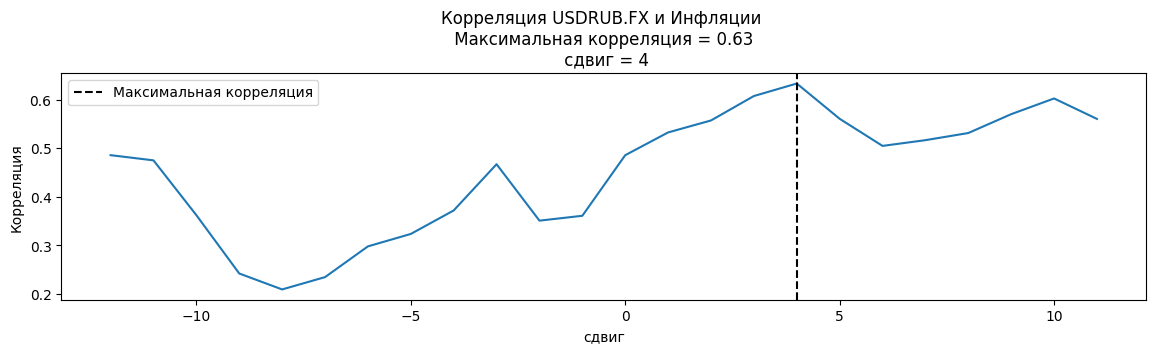

In [8]:
plot_lag_max_par(last_date='1998-01')

Инфляция - RUB.INFL


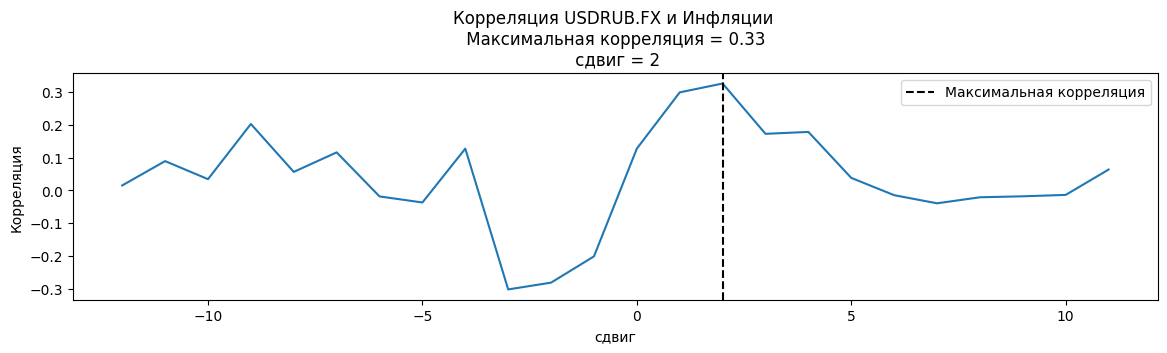

In [23]:
plot_lag_max_par(first_date='2014-01')

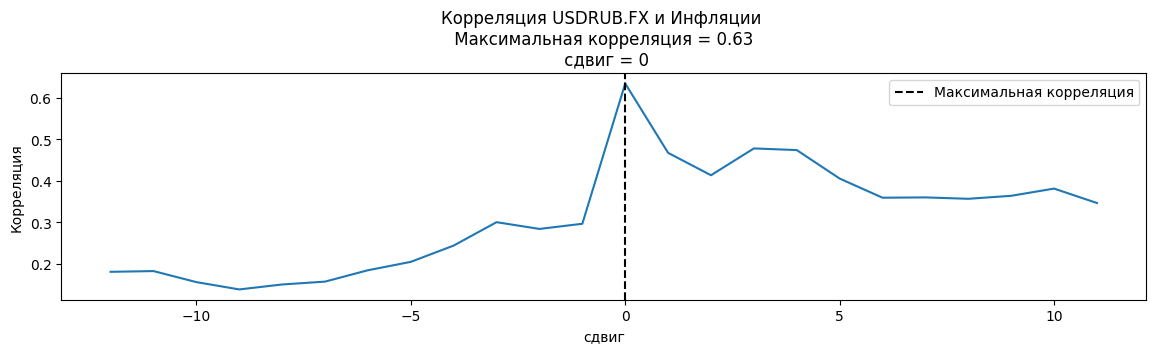

In [27]:
plot_lag_max_par(first_date='1990-01', last_date='2014-01')

### Корреляция инфляции в других странах

Инфляция - USD.INFL


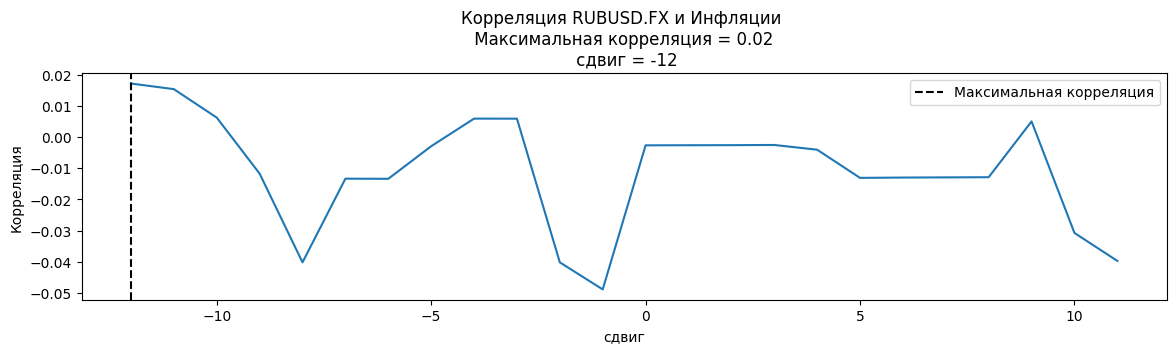

In [12]:
plot_lag_max_par(ccy='RUBUSD.FX')

Инфляция - USD.INFL


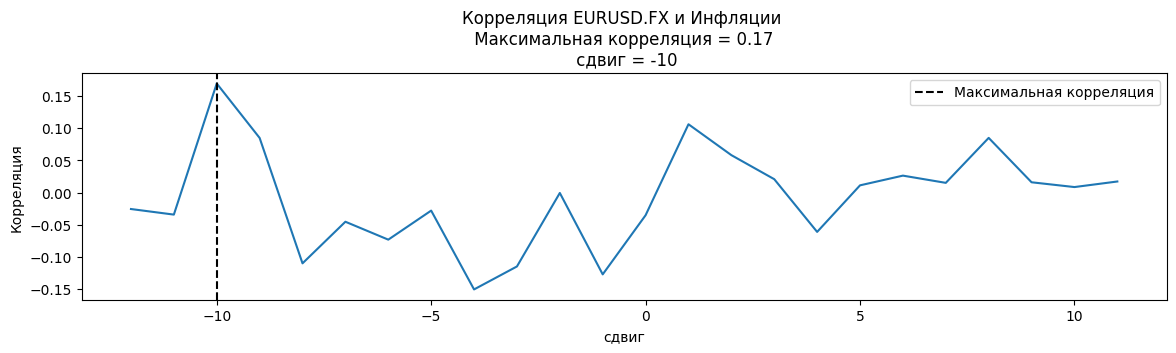

In [25]:
plot_lag_max_par(ccy='EURUSD.FX')

Инфляция - EUR.INFL


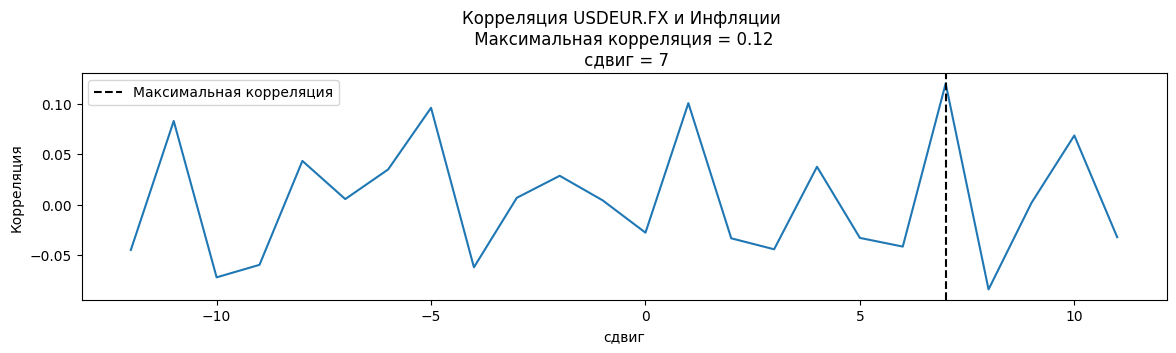

In [11]:
plot_lag_max_par(ccy='USDEUR.FX')

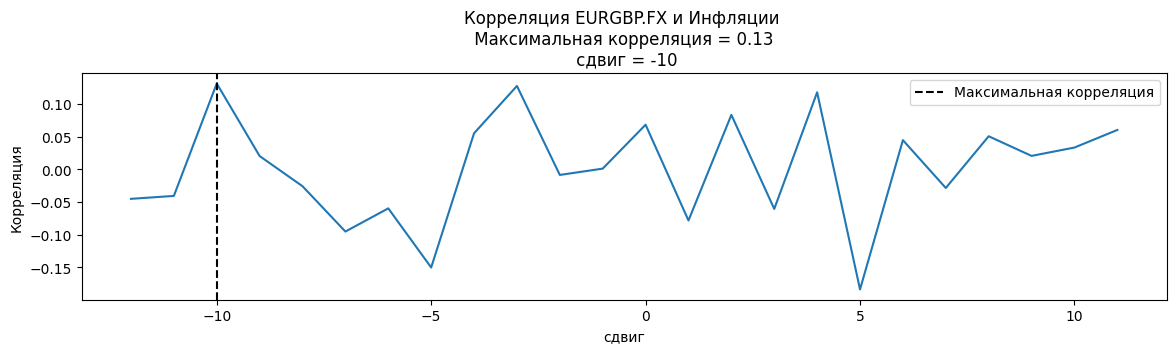

In [12]:
plot_lag_max_par(ccy='EURGBP.FX')

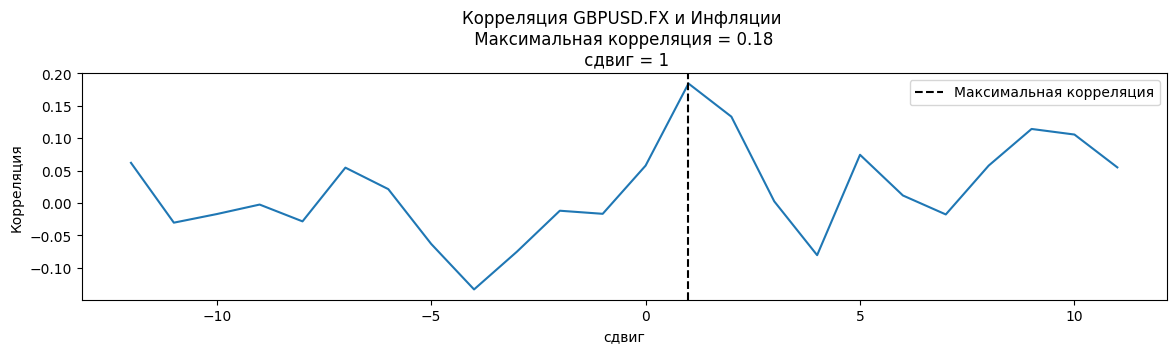

In [15]:
plot_lag_max_par(ccy='GBPUSD.FX')

Инфляция - USD.INFL


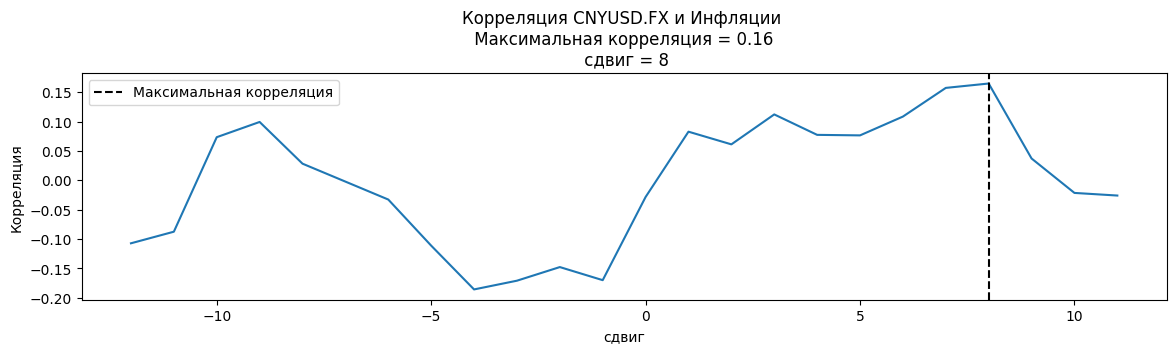

In [27]:
plot_lag_max_par(ccy='CNYUSD.FX')

Инфляция - CNY.INFL


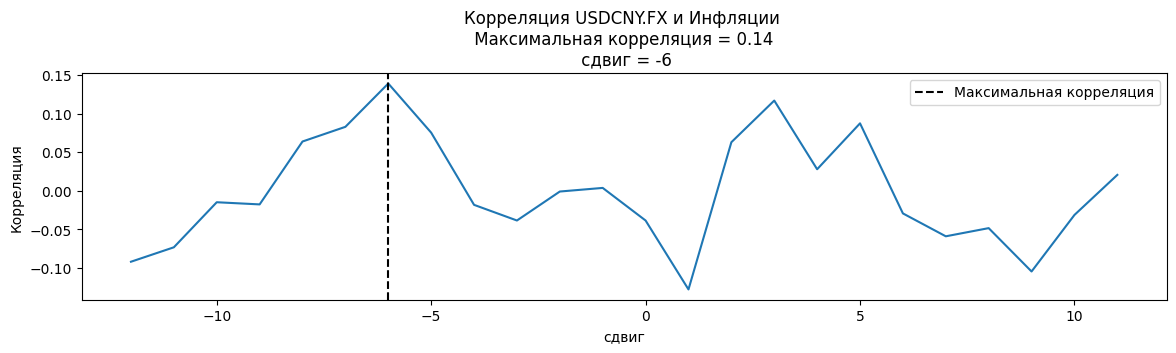

In [28]:
plot_lag_max_par(ccy='USDCNY.FX')

### Скользящая корреляция (Rolling Correlation)

In [9]:
def plot_rolling_corr(ccy: str = 'USDRUB.FX', window: int = 10, first_date: str = '1990-01', last_date=None, lag=0):
    """
    Построение графика скользящей корреляции с учетом задержки (lag).
    """
    asset = ok.Asset(ccy)
    ccy_short = asset.currency
    print(f"Инфляция - {asset.inflation}")
    usd = ok.AssetList([ccy], first_date=first_date, last_date=last_date, ccy=ccy_short, inflation=True)  
    ror = pd.concat([usd.assets_ror.shift(lag), usd.inflation_ts], axis=1, join='outer')
    cov_matrix_ts = ror.rolling(window=window * 12).corr()
    cov_matrix_ts = cov_matrix_ts.drop(index=ror.columns[1:], level=1).droplevel(1)
    cov_matrix_ts.drop(columns=ror.columns[0], inplace=True)
    cov_matrix_ts.dropna(inplace=True)
    print(f"Максимумы: {cov_matrix_ts.nlargest(5, asset.inflation)}")
    cov_matrix_ts.plot()
    ax = plt.gca()
    ax.set_title(f'Скользящая {window}-летняя корреляция между {ccy} и инфляцией \n сдвиг = {lag}')
    ax.set_ylabel('Корреляция')
    ax.set_xlabel('')
    ax.legend('')

Инфляция - RUB.INFL
Максимумы:          RUB.INFL
date             
2003-08  0.971583
2003-07  0.954658
2003-06  0.954102
2003-05  0.953418
2003-04  0.953073


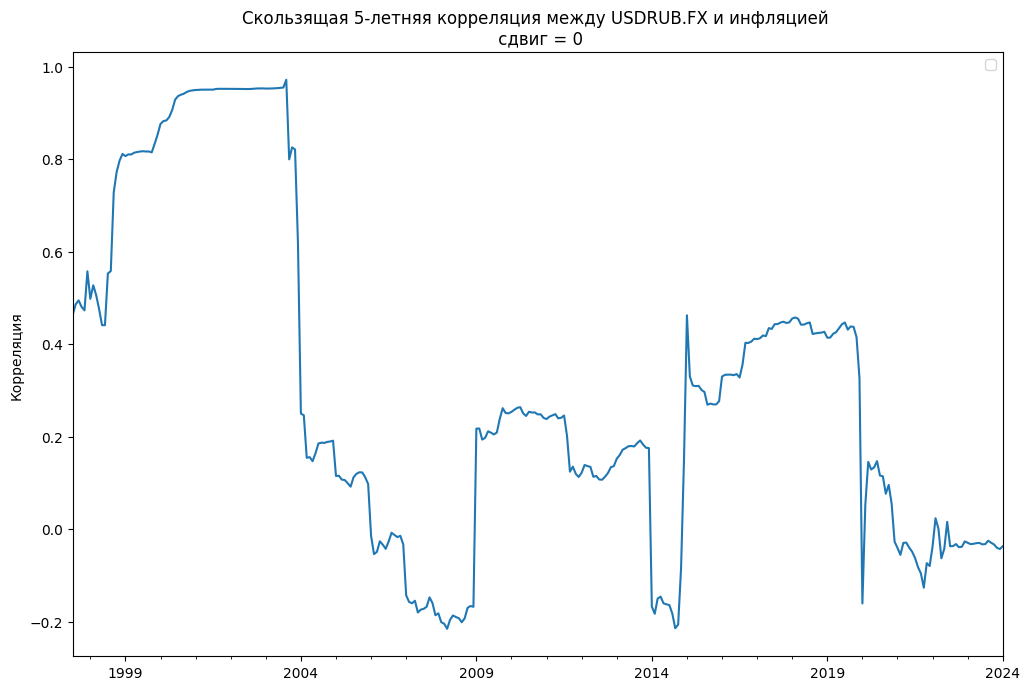

In [10]:
plot_rolling_corr(window=5, lag=0)

Инфляция - RUB.INFL
Максимумы:          RUB.INFL
date             
2008-08  0.959617
2008-07  0.945415
2008-06  0.945068
2007-12  0.944709
2007-11  0.944684


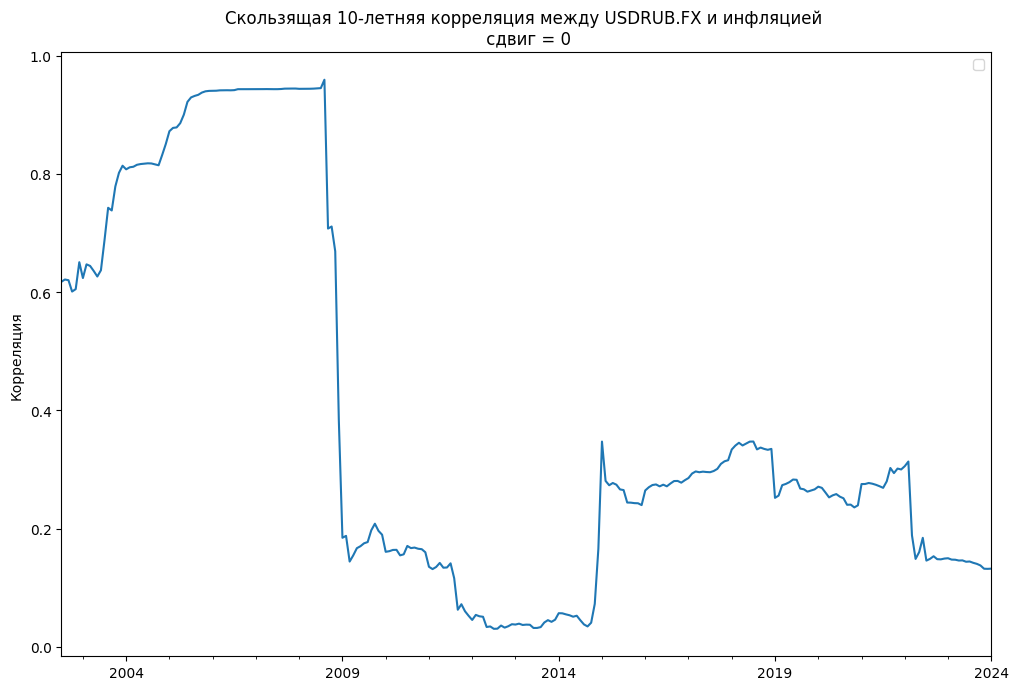

In [11]:
# Рост корреляции после окончания политики "валютного коридора" ЦБ
plot_rolling_corr(window=10, lag=0)

Инфляция - RUB.INFL


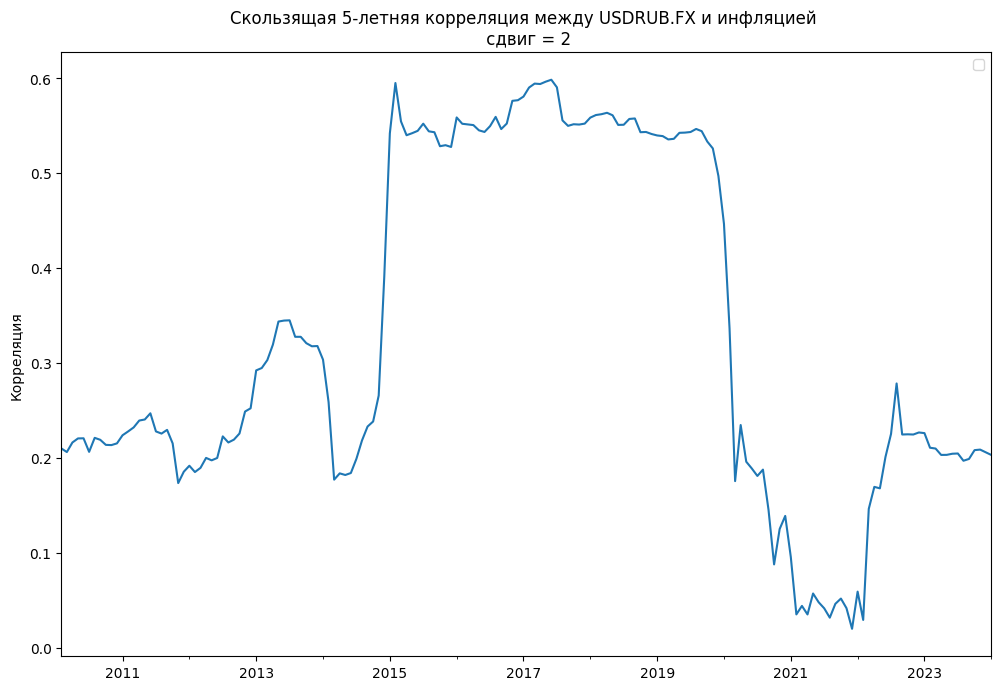

In [9]:
plot_rolling_corr(window=5, lag=2, first_date='2005-01')

Инфляция - RUB.INFL


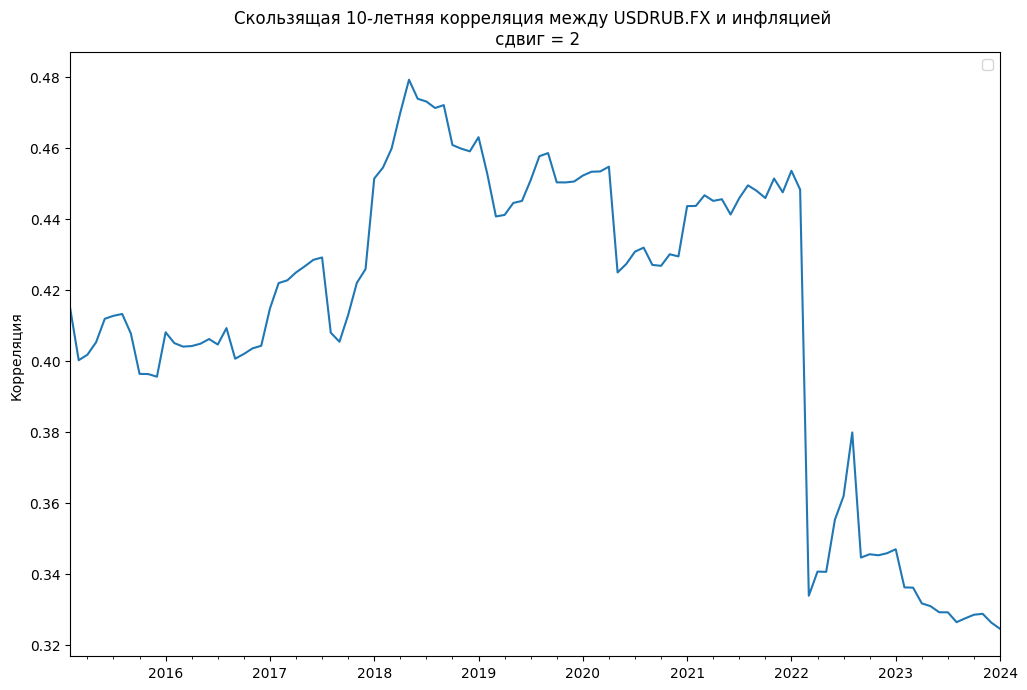

In [10]:
plot_rolling_corr(window=10, lag=2, first_date='2005-01')

Инфляция - RUB.INFL


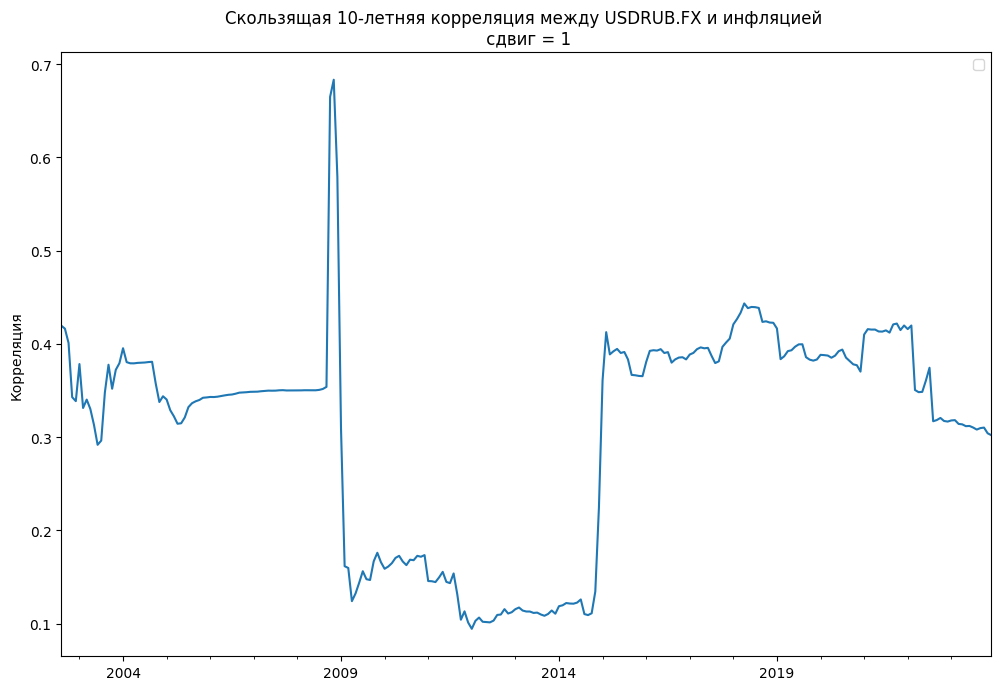

In [38]:
plot_rolling_corr(window=10, lag=1)

## Скользящая корреляция в других странах

Инфляция - USD.INFL


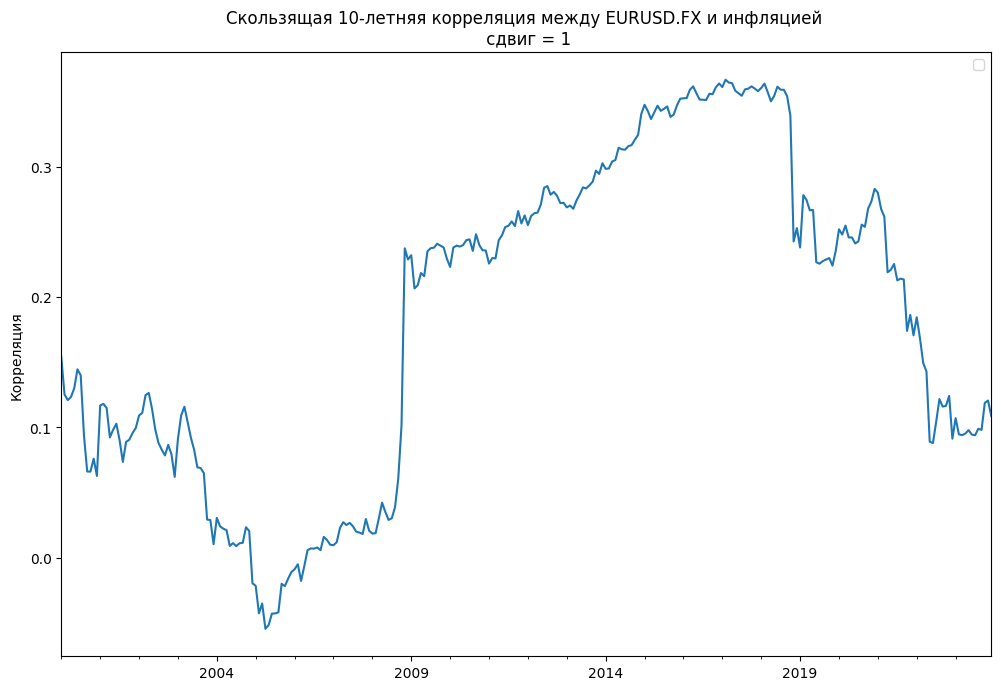

In [41]:
plot_rolling_corr(ccy='EURUSD.FX', window=10, lag=1)

Инфляция - EUR.INFL
Максимумы:          EUR.INFL
date             
2022-12  0.225336
2023-01  0.221913
2023-02  0.219767
2022-10  0.211128
2022-11  0.210128


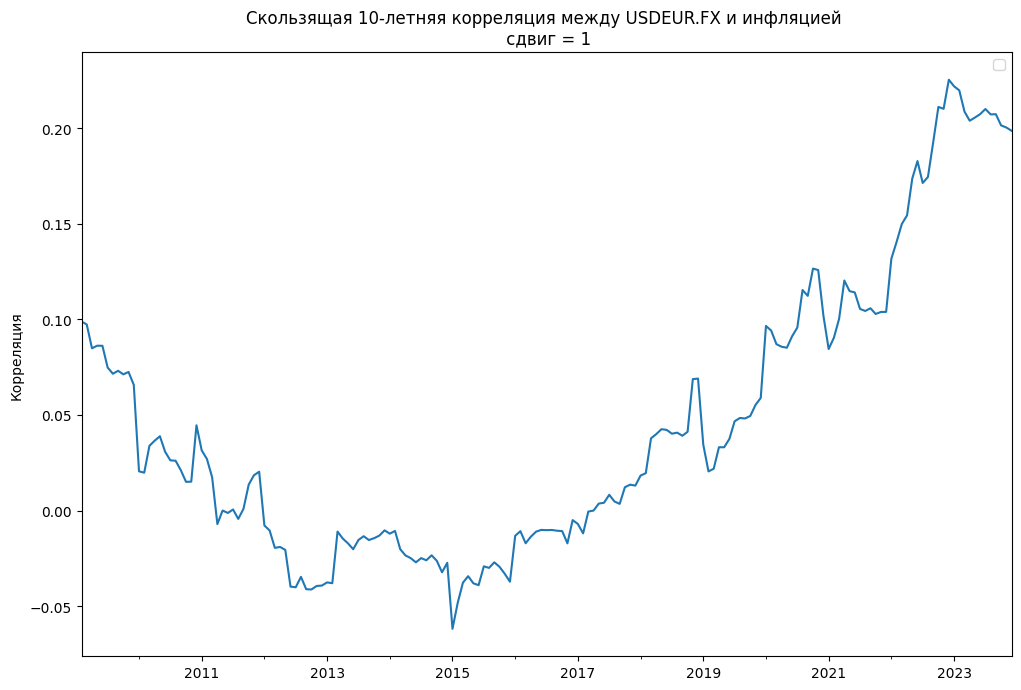

In [12]:
plot_rolling_corr(ccy='USDEUR.FX', window=10, lag=1)

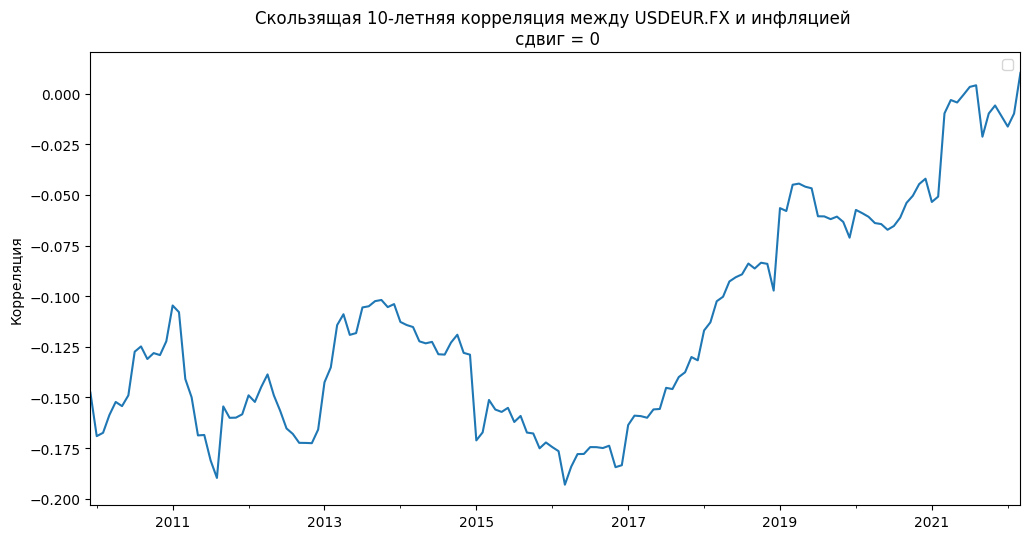

In [35]:
plot_rolling_corr(ccy='USDEUR.FX', window=10)

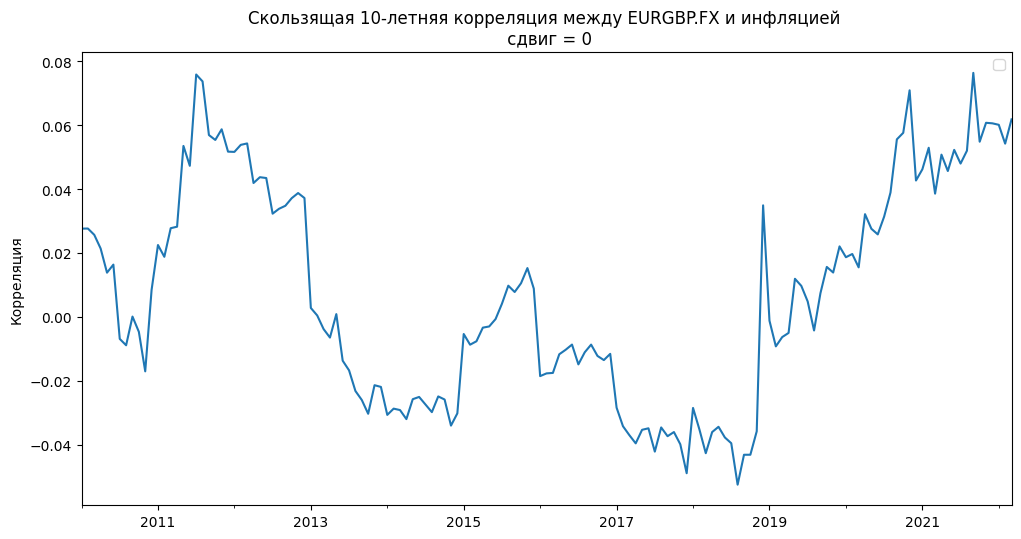

In [36]:
plot_rolling_corr(ccy='EURGBP.FX', window=10)

Инфляция - EUR.INFL
Максимумы:          EUR.INFL
date             
2021-07  0.032829
2021-08  0.032254
2022-02  0.030653
2022-01  0.028673
2021-10  0.028041


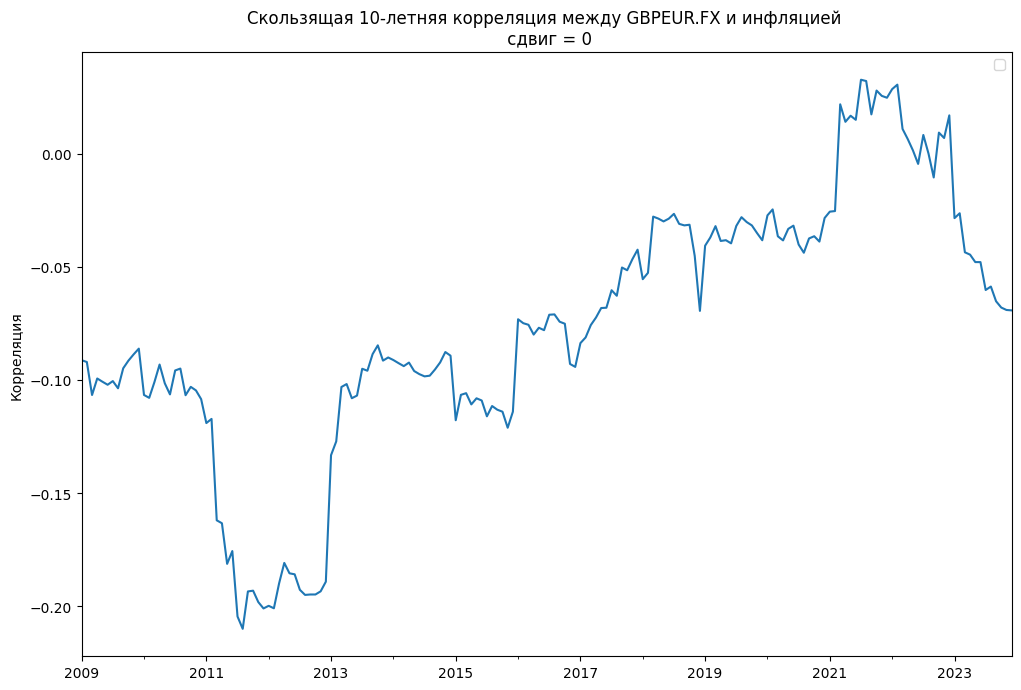

In [13]:
# 2020 год - Брексит
plot_rolling_corr(ccy='GBPEUR.FX', window=10, lag=0)

Инфляция - EUR.INFL


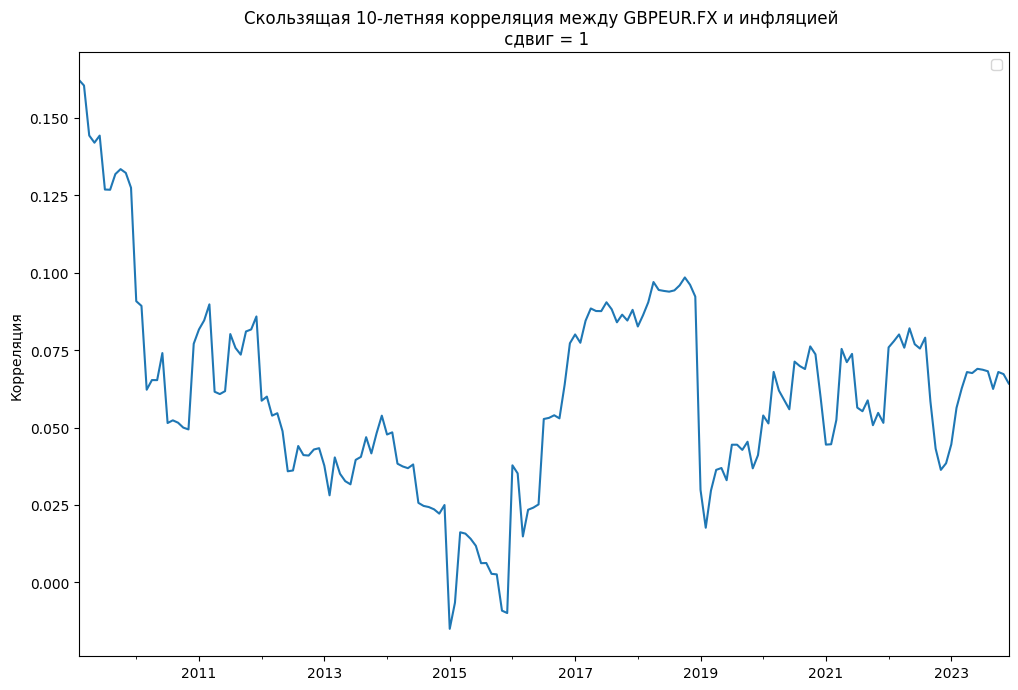

In [49]:
# 2020 год - Брексит
plot_rolling_corr(ccy='GBPEUR.FX', window=10, lag=1)

Инфляция - EUR.INFL


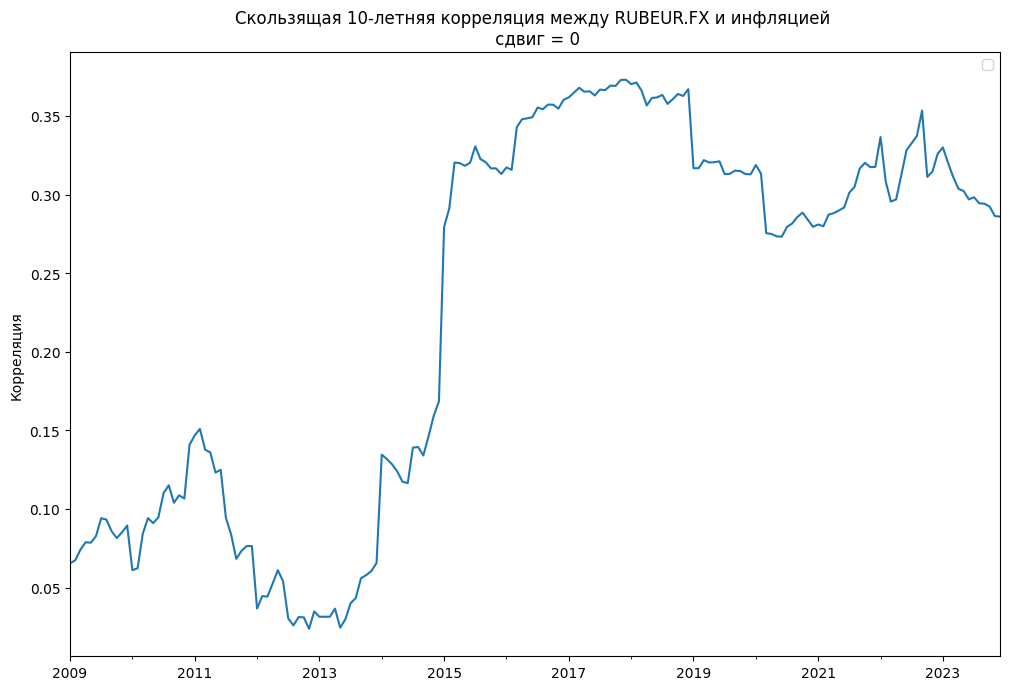

In [44]:
plot_rolling_corr(ccy='RUBEUR.FX', window=10)

Инфляция - RUB.INFL


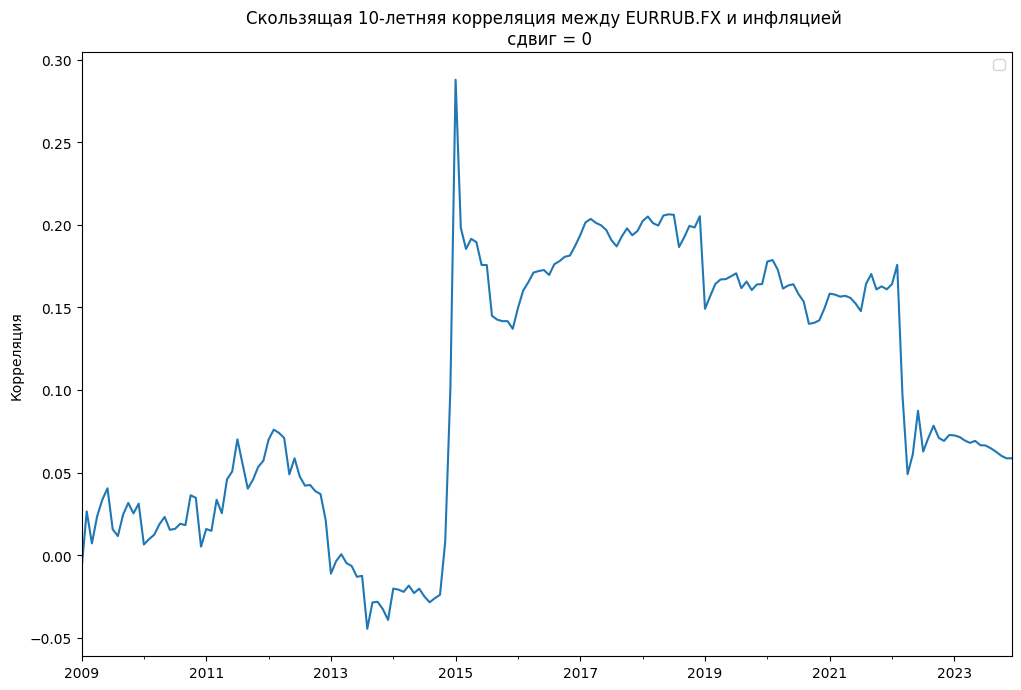

In [45]:
plot_rolling_corr(ccy='EURRUB.FX', window=10)